# Run a genetic optimization
In this notebook, we demonstrate how to set the parameters for the genetic algorithm with the controller shown in the previous notebook. We will also try to explain how to create custom parameters for other controllers (TODO).

In [30]:
# coding: utf8
import os, sys
from sys import argv
sys.path.insert(0, os.getcwd()) # adds current directory to python path

from isae.optim.genAlg import *
from isae.optim.multiprocessGenAlg import *
from datetime import datetime

# Colors for console outputs
BLUE = "\033[34m"
GREEN = "\033[32m"
DEFAULT = "\033[39m"
YELLOW = "\033[33m"
CYAN = "\033[36m"
RED = "\033[91m"

## Genetic algorithm initialization
Here, we instantiate the `geneticAlgorithm` class (using 1 CPU) or the `multiprocessGeneticAlgorithm` class (using all CPUs) that will handle the optimization process : population initialization, evaluation, reproduction, and mutation for a given number of solutions and of generations.

In [31]:
#GA = geneticAlgorithm()
GA = multiprocessGeneticAlgorithm()

## Setting the hyperparameters
We now set the hyperparameters, i.e. the parameters of the optimization process itself.

In [32]:
GA.pop_size = 12
# Number of solutions at each generation, needs to be a mutiple of 4
GA.n_gen = 5
# Number of generations i.e. optimization steps on the population
GA.grade_index = 3 
# in gradedSimulation objects, will use gradedSim.grades[grade_index] as optimization goal (maximization)

## (TEMPORARY) Setting the simulation initialization function
The current implementation requires to write a custom simulation initialization function `paramToSim` for each set of parameters that the genetic algorithm will optimize. It takes as inputs a genAlgParam[] list of parameters, and returns a `gradedSimulation` instance defined as needed to fit the input prameters. We demonstrate 1 example here that optimizes : 
- max. dist. between front hips and feet : `bh0 = paramsInstance[0].value`
- max. dist. between rear hips and feet : `bh1 = paramsInstance[1].value`
- foot target trajectory, as `footTrajectory` instance : `trajPoints0 = paramsInstance[2].value`

These parameters can be optimized by the genetic algorithm because they implement a `genAlgParam` wrapper class, that allows them to be manipulated for random initialization, reproduction and mutation steps. The `paramToSim` function is used as an external parameter to define the evaluation step.

If you checkout the branch to develop it yourself, make sure to also modify the `genAlg` class to reflect new `genAlgParam` you implement : in the `genAlg.initPopulation()` method, you should add a string allowing to define the initialization of this new parameter. 

In [33]:
def paramToSim_Bh_Traj(paramsInstance):
    # Mapping input parameters to controller parameters
    bh0 = paramsInstance[0].value
    bh1 = paramsInstance[1].value
    trajPoints0 = paramsInstance[2].value

    # Loop parameters 
    pyb_gui = False
    duration = 8
    period = 1.2

    offsets = [0.5,0.,0.5,0.]
    bodyHeights = 2*[bh0] + 2*[bh1]

    footTraj1 = footTrajectory(           trajPoints0              , phaseOffset = offsets[0])
    footTraj2 = footTrajectory(         footTraj1.points           , phaseOffset = offsets[1])
    footTraj3 = footTrajectory(         footTraj1.points           , phaseOffset = offsets[2])
    footTraj4 = footTrajectory(         footTraj1.points           , phaseOffset = offsets[3])
    trajs = [footTraj1, footTraj2, footTraj3, footTraj4]

    leg = Leg(1,1)
    sols = [False, False, True, True]
    #sols = [True, True, False, False]
    #sols = [False, False, False, False]
    #sols = [True, True, True, True]
    
    Kp = 10
    Kd = 0.2

    robotController = footTrajController(bodyHeights, leg, sols, trajs, period, Kp, Kd, 3 * np.ones((8, 1)))
    
    # Initialize gradedSimulation, stop right before gradedSim.initializeSim()
    simInstance = gradedSimulation()
    simInstance.setLoopParams(pyb_gui, duration, leg)
    simInstance.setController(robotController)

    return simInstance

# Assign paramToSim function to GA
GA.setParamToSim(paramToSim_Bh_Traj)

## Defining the parameters to optimize
This is where we define the `genAlgParam` classes that we want to instantiate for each potential solution, mostly setting parameters for their random initiaization ranges in `paramArgs`.

In [34]:
# params : bh1, bh2, footTraj
paramTypes = ["scalar", "scalar", "ptFtTraj"]
paramArgs = [[1.,1.6],[1.,1.6],[[-1.2,1.2],[0,1.],[3,5]] ]
paramNames = ["BH0", "BH1", "FootTraj"]

Finally, we assign these parameters to the genetic agorithm :

In [35]:
GA.setParamTypes(paramTypes)
GA.setParamArgs(paramArgs)
GA.setParamNames(paramNames)

The following lines simply run the optimization process with console output and generate a log file, populated along the optimization process by the `geneticAlgorithm` class.

In [36]:
GA.runOptim()
genLog = GA.genLog




GEN 0
Pop size : 12
##########################################
Simulation finished in 5.9559809999999995 s
##########################################
Indiv. vyBXxWU : 
[1.0137640887539985 1.462418325474701
 array([[-1.18422423e+00,  9.50670852e-04],
       [-1.61074668e-01,  5.87599748e-01],
       [ 2.40521517e-01,  4.97707329e-01],
       [ 8.08267293e-01,  1.43028800e-01],
       [ 1.17443976e+00,  5.26734790e-01],
       [-1.18422423e+00,  9.50670852e-04]])]
Fitness : 0.16291181116620707


##########################################
Simulation finished in 5.970718000000001 s
##########################################
Indiv. OLYtNSh : 
[1.5334382409169995 1.1349783828457527
 array([[-0.9550914 ,  0.90158338],
       [-0.06047581,  0.98465005],
       [-0.19718124,  0.15055747],
       [-0.29117974,  0.77792131],
       [-0.91652784,  0.65071841],
       [-0.9550914 ,  0.90158338]])]
Fitness : -0.004990025384663656


##########################################
Simulation finished in

       [-0.84856076,  0.57872737]])]

Fitness : 1.8424114786356731


##########################################
Simulation finished in 8.012842000000001 s
##########################################
Indiv. nrCtuXk : 
[1.099301431916883 1.4534099052116989
 array([[-1.00020844,  0.03799791],
       [-0.35672058,  0.66506772],
       [ 0.59856031,  0.05371358],
       [-0.86850512,  0.0053232 ],
       [-1.00020844,  0.03799791]])]
Fitness : 1.3885015835281902


##########################################
Simulation finished in 8.059867 s
##########################################
Indiv. sUPrAde : 
[1.1626653921504164 1.4235070335083067
 array([[-0.88540738,  0.73762153],
       [ 0.73530723,  0.96957388],
       [ 1.16502454,  0.79672974],
       [ 0.55669159,  0.45836706],
       [-0.55396119,  0.34097542],
       [-0.88540738,  0.73762153]])]
Fitness : 0.8458873726965119

##########################################
Simulation finished in 8.064991000000001 s
###############################

##########################################
Indiv. KjJeTfh : 
[1.3323253294165318 1.0827212820602699
 array([[-0.80933044,  0.60520866],
       [ 0.34114414,  0.5701508 ],
       [ 0.7776014 ,  0.96213542],
       [-0.18115167,  0.21451095],
       [-0.51485621,  0.39661916],
       [-0.80933044,  0.60520866]])]
Fitness : 2.2977323759959734


##########################################
Simulation finished in 5.626076 s
##########################################
Indiv. qDrVZga : 
[1.3457478367864268 1.065403941092067
 array([[-0.31282901,  0.19514345],
       [ 0.35438288,  0.59085432],
       [ 0.80463639,  0.99809746],
       [-0.18115167,  0.21451095],
       [-0.51485621,  0.39661916],
       [-0.31282901,  0.19514345]])]
Fitness : 2.6756403870795964


##########################################
Simulation finished in 5.858346 s
##########################################
Indiv. WpHjJbV : 
[1.4470041880013689 1.0
 array([[-0.31282901,  0.19514345],
       [ 0.35438288,  0.59085432],
   

       [-0.31282901,  0.19514345]])]
Fitness : 2.6756403870795964


##########################################
Simulation finished in 7.918429000000001 s
##########################################
Indiv. jRqFrOL : 
[1.260687427862838 1.0785451283374639
 array([[-0.31282901,  0.19514345],
       [ 0.35438288,  0.59085432],
       [ 0.80463639,  0.99809746],
       [-0.16148724,  0.21738495],
       [-0.31282901,  0.19514345]])]
Fitness : 0.9838854342857773


##########################################
Simulation finished in 8.004652 s
##########################################
Indiv. PVnfzSo : 
[1.2359443095280431 1.2438990505595466
 array([[-0.80933044,  0.60520866],
       [ 0.34114414,  0.5701508 ],
       [ 0.7776014 ,  0.96213542],
       [ 0.79360366,  0.53496971],
       [-0.80933044,  0.60520866]])]
Fitness : 0.07542867105119934


##########################################
Simulation finished in 8.27159 s
##########################################
Indiv. zhURdXw : 
[1.35183138337

## Interpreting the log
We can now exploit the results contained in `genLog` : it is a numpy array, which can also be stored as a .npy file.

The log structure is a $n_{gen}*2*n_{solutions}$ array, the first column in the second dimension being the scores and the second being the corresponding sets of parameters. Each generation is sorted in descending order according to the score. Here, we show a few examples of how to access the data there.

In [37]:
## Save the log to a file labeled by the date and time
#date = datetime.now()
#np.save("optim_logs/optim_" + date.strftime("%d_%m_%Y_%H:%M:%S") + "_log.npy", genLog, allow_pickle=True)

# Scores of gen k:
k = 3
print(genLog[k,0])

#print(genLog)

#Compute the average score by generation 
print(np.average(genLog[:,0], axis=1))

# Best score by generation
bestByGen = genLog[:,0,0]
print("Best score by gen. :\n{}\n".format(bestByGen))

# Best parameters at last generation
bestPLastGen = genLog[-1,1,0]
print("Best params at last gen. :\n{}\n".format(bestPLastGen))

[3.4922079240519968 2.946819109375554 2.6756403870795964
 2.6623574784601303 2.6327646132938507 2.2977323759959734
 2.2299286432481433 2.2218147197053435 1.529549388285858
 1.4378575500196873 1.3150607924343518 1.0709241239075553]
[0.7815670591188751 1.3513859525809842 1.5764060634659358
 2.209388092154837 1.7697847915182843]
Best score by gen. :
[2.8018852688120055 2.7617818448284344 2.7617818448284344
 3.4922079240519968 3.4922079240519968]

Best params at last gen. :
[1.157481726270473 1.5103224746565804
 array([[-1.17877124,  0.19936363],
       [-0.17045346,  0.70411965],
       [ 0.00203901,  0.123086  ],
       [ 0.79360366,  0.53496971],
       [-1.17877124,  0.19936363]])]



## Plot tests (not in the git yet)

<IPython.core.display.Javascript object>


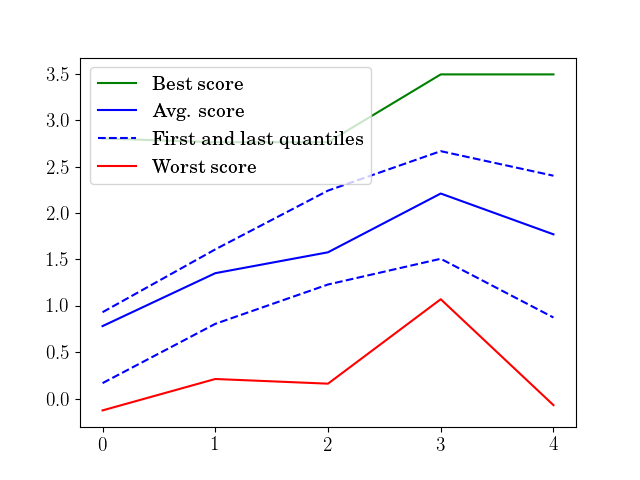

In [38]:
bestByGen = genLog[:,0,0]
avgByGen = np.average(genLog[:,0], axis=1)
worstByGen = genLog[:,0,-1]

# show first, median and last quantile
quantByGen = []
nbQuantiles = 4
for i in range(nbQuantiles):
    quantByGen.append(np.quantile(genLog[:,0], i/nbQuantiles, axis=1))

%matplotlib notebook
plt.plot(bestByGen, 'g', label='Best score')
plt.plot(avgByGen, 'b', label='Avg. score')
plt.plot(quantByGen[1], 'b--', label='First and last quantiles')
plt.plot(quantByGen[nbQuantiles-1], 'b--')
plt.plot(worstByGen, 'r', label='Worst score')
plt.legend()